In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import minimize

def simulate_complex_recursion(N, a, b, c, num_iterations):
    """
    Simulates the recursive equation for N complex variables.
    
    Parameters:
    N (int): Number of variables x_i.
    a (float): Scalar parameter.
    b (float): Scalar parameter.
    c (ndarray): N-length array representing costs.
    num_iterations (int): Number of iterations to perform.
    
    Returns:
    ndarray: An array of shape (num_iterations, N) containing the evolution of x_i.
    """
    # Ensure c is a NumPy array
    c = np.asarray(c)
    # Initial condition
    x = np.full(N, 1/np.sqrt(N), dtype=np.complex128)
    
    # Precompute constants
    
    
    # Store iterations
    history = np.zeros((num_iterations, N), dtype=np.complex128)
    cost=np.zeros(num_iterations)
    mean_history = np.zeros(num_iterations, dtype=np.complex128)
    for n in range(num_iterations):
        exp_ib_pi2 = np.exp(1j * (b[n] + np.pi) / 2)
        sin_b2 = np.sin(b[n] / 2)
        history[n] = x  # Store current state
        mean_history[n] = np.mean(x) 
        # Compute the sum term
        sum_term = np.sum(x * np.exp(1j * a[n] * c)) / N
        
        # Update x_i for all i
        x = x * np.exp(1j * a[n] * c) + 2 * exp_ib_pi2 * sin_b2 * sum_term
        cost[n]=np.dot(np.abs(x)**2,c)
    return history,mean_history,cost



def plot_evolution(history,mean_history,c):
    """
    Plots the evolution of the N complex variables on the complex plane.
    
    Parameters:
    history (ndarray): Array of shape (num_iterations, N) containing the evolution of x_i.
    """
    scale=np.max(np.abs(history))
    num_iterations, N = history.shape
    cmap = cm.viridis  # Use the viridis colormap for coloring points based on c values
    plt.figure(figsize=(8, 8))
    for n in range(num_iterations):
        plt.clf()
        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.scatter(history[n].real, history[n].imag, c=c, cmap=cmap, edgecolors='k')
        plt.scatter(mean_history[n].real, mean_history[n].imag, color='red', marker='x', s=100, label='Mean x')
        plt.xlim(-scale, scale)
        plt.ylim(-scale, scale)
        plt.xlabel('Real')
        plt.ylabel('Imaginary')
        plt.title(f'Step {n + 1}/{num_iterations}')
        plt.pause(0.1)  # Pause to visualize step-by-step
    plt.show()




In [2]:
import numpy as np


def cost_function(c, alpha, beta, k, j, l,r, N, num_iterations, method):
    a = np.ones(num_iterations)
    b = np.ones(num_iterations)

    if method == 'lin':
        for n in range(num_iterations):
            a[n] = k * n / num_iterations + alpha
        for m in range(num_iterations):
            b[m] = -j * m / num_iterations + beta

    elif method == 'exp':
        for n in range(num_iterations):
            a[n] =l* (1 - np.exp(k *(n + 1) / num_iterations)) + alpha
        for m in range(num_iterations):
            b[m] = r* np.exp(j * (m + 1) / num_iterations)+ beta

    elif method == 'const':
        a.fill(alpha)
        b.fill(beta)

    _, _, cost = simulate_complex_recursion(N, a, b, c, num_iterations)
    return cost[-1]
    #return np.max(cost)

def optimize_cost(c, N, num_iterations, method):
    # Wrapper for optimization
    def neg_cost(params):
        if method == 'const':
            alpha, beta = params
            return -cost_function(c, alpha, beta, 0, 0, 0, 0, N, num_iterations, method)
        if method == 'exp':
            alpha, beta, k, j,l,r = params
            return -cost_function(c, alpha, beta, k, j,l,r, N, num_iterations, method)
        if method == 'lin':
            alpha, beta, k, j = params
            return -cost_function(c, alpha, beta, k, j, 0, 0, N, num_iterations, method)

    # Initial guesses
    if method == 'const':
        initial_guess = [1.0, 1.0]  # alpha, beta
        bounds = [(-10, 10), (-10, 10)]
    if method == 'lin':
        initial_guess = [1.0, 1.0, 1.0, 1.0]  # alpha, beta, k, j
        bounds = [(-10, 10), (-10, 10), (0.0, 10.0), (0.0, 10.0)]
    if method == 'exp':
        initial_guess = [1.0, 1.0,0,0, 1.0, 1.0]  # alpha, beta, k, j
        bounds = [(-10, 10), (-10, 10),(-5.0, 5.0),(-5.0, 5.0), (0.0, 10.0), (0.0, 10.0)]

    result = minimize(neg_cost, initial_guess, method='L-BFGS-B', bounds=bounds)

    if method == 'const':
        alpha, beta = result.x
        k, j,l,r = None, None,None,None
    if method == 'lin':
        alpha, beta, k, j = result.x
        l, r = None, None
    if method == 'exp':
        alpha, beta, k, j,l,r = result.x
    max_cost = -result.fun

    return [alpha,beta,k,j,l,r,max_cost]


In [3]:
N=10000
c=np.sort(np.random.beta(10,10,N))

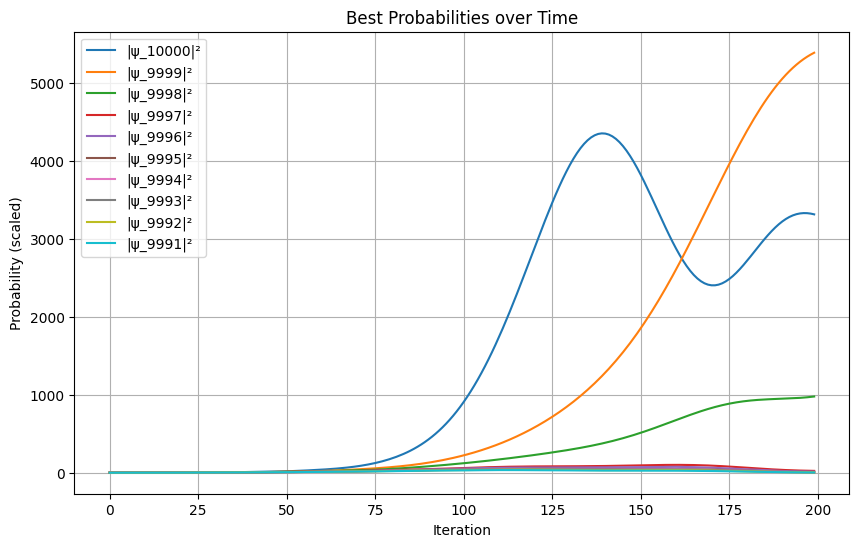

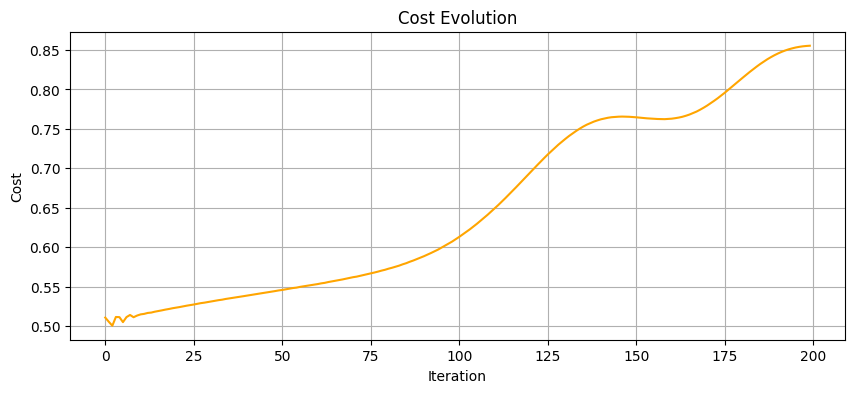

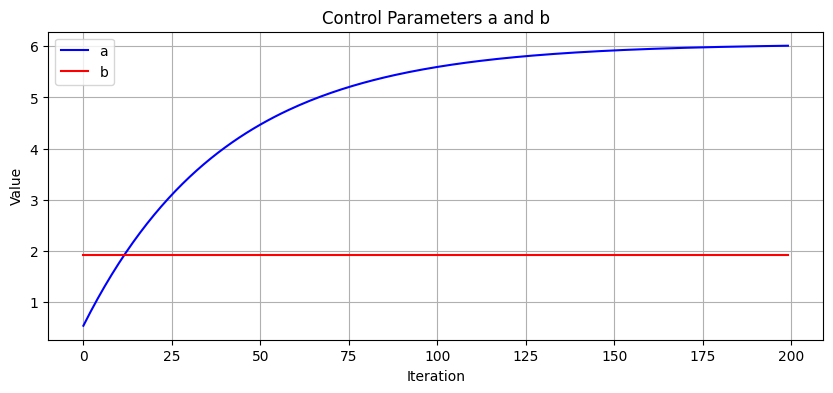

In [4]:
num_iterations=int(2*np.sqrt(N))
method='exp'
result=optimize_cost(c, N, num_iterations, method)
# Reconstruct parameters
a = np.ones(num_iterations)
b = np.ones(num_iterations)
alpha = result[0]
beta = result[1]
k = result[2]
j = result[3]
l=result[4]
r=result[5]

if method == 'lin':
    for n in range(num_iterations):
        a[n] = k * n / num_iterations + alpha
    for m in range(num_iterations):
        b[m] = -j * m / num_iterations + beta

elif method == 'exp':
    for n in range(num_iterations):
        a[n] =l* (1 - np.exp(k *(n + 1) / num_iterations)) + alpha
    for m in range(num_iterations):
        b[m] = r* np.exp(j * (m + 1) / num_iterations)+ beta

elif method == 'const':
    a.fill(alpha)
    b.fill(beta)

# Run simulation
history, mean_history, cost = simulate_complex_recursion(N, a, b, c, num_iterations)

# 1. Plot best probabilities (all together in one figure)
best = 10
best_probs = []
for k in range(1, best + 1):
    best_probs.append([np.abs(history[i][-k])**2 for i in range(num_iterations)])

plt.figure(figsize=(10, 6))
for k in range(best):
    plt.plot(np.array(best_probs[k]) / (1 / N), label=f'|ψ_{N-k}|²')
plt.title("Best Probabilities over Time")
plt.xlabel("Iteration")
plt.ylabel("Probability (scaled)")
plt.legend()
plt.grid(True)

# 2. Plot cost evolution
plt.figure(figsize=(10, 4))
plt.plot(cost, color='orange')
plt.title("Cost Evolution")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)

# 3. Plot a and b evolution
plt.figure(figsize=(10, 4))
plt.plot(a, label='a', color='blue')
plt.plot(b, label='b', color='red')
plt.title("Control Parameters a and b")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.show()

In [46]:
#plot_evolution(history,mean_history,c)